In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sportran as st
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [641]:
from scipy.interpolate import CubicSpline, interp1d
def model_scalar(x, y):
    return CubicSpline(np.concatenate([-x[::-1], x[1:]]), np.concatenate([y[::-1], y[1:]]))

n = 2
def model_wishart_(x, y):
    xx = np.concatenate([-x[::-1], x[1:]])
    l = x.size
    y00, y01, y11 = y.reshape(3,l)
    yy = np.array([[y00, y01], [np.zeros_like(y01), y11]]).T
    # yy = np.einsum('tab,tbc->tac', np.transpose(yy, axes=(0,2,1)), yy)
    yy = np.concatenate([yy[::-1], yy[1:]])
    # return interp1d(xx, yy)) 
    return CubicSpline(xx, yy) #, bc_type = 'clamped')

import numpy as np
from scipy.interpolate import CubicSpline

def model_wishart(x, y, N):
    xx = np.concatenate([-x[::-1], x[1:]])
    l = x.size
    upper_triangle_indices = np.triu_indices(N)
    y_elements = y.reshape(len(upper_triangle_indices[0]), l)
    
    yy = np.zeros((l, N, N))
    for k, (i, j) in enumerate(zip(*upper_triangle_indices)):
        yy[:, j, i] = y_elements[k]
    
    yy = np.concatenate([yy[::-1], yy[1:]])
    return CubicSpline(xx, yy)

def mini_model_w(x, y, N):
    xx = np.concatenate([-x[::-1], x[1:]])
    l = x.size
    
    # y.shape should be l*N**2
    yy = y.reshape(l, N**2)
    yy = np.concatenate([yy[::-1], yy[1:]])
    return CubicSpline(xx, yy)

def mini_model_w_real(x, y, N):
    xx = np.concatenate([-x[::-1], x[1:]])
    l = x.size
    
    # y.shape should be l*N**2
    yy = y.reshape(l, N*(N+1)//2)
    yy = np.concatenate([yy[::-1], yy[1:]])
    return CubicSpline(xx, yy)


In [374]:
x = np.arange(10)
y = np.random.randn(40)
spl = mini_model_w(x, y, 2)

In [348]:
dc=np.load('data/bayesian/CsF/dc_minimal.npy', allow_pickle = True).item()

In [453]:
def split_bl(array):
    s = array.shape[0]//2
    return np.hstack([array[:s], array[s:]])

In [832]:
flux = st.HeatCurrent([
    # dc['qflux'],
    # dc['ele_flux']
    split_bl(dc['qflux']),
    split_bl(dc['ele_flux'])
    ],
    DT_FS=1,
    TEMPERATURE=dc['Temeprature'],
    VOLUME=dc['Volume'],
    UNITS='metal')

Using multicomponent code.


In [833]:
flux_resample=flux.resample(fstar_THz=20)

Using multicomponent code.
-----------------------------------------------------
  RESAMPLE TIME SERIES
-----------------------------------------------------
 Original Nyquist freq  f_Ny =     500.00000 THz
 Resampling freq          f* =      20.00000 THz
 Sampling time         TSKIP =            25 steps
                             =        25.000 fs
 Original  n. of frequencies =         50001
 Resampled n. of frequencies =          2001
 min(PSD)          (pre-filter&sample) =      0.00000
 min(PSD)         (post-filter&sample) =      0.00124
 % of original PSD Power f<f* (pre-filter&sample)  = 99.365 %
 fPSD not calculated before resampling
 -----------------------------------------------------



# Diagonal (thermal)

In [876]:
flux_resample.maxlike_estimate(model_scalar, n_parameters = 9, likelihood='chisquare', 
                                solver = 'BFGS',
                                minimize_kwargs = {
                                'tol': 1e-10,
                                'jac': '3-point',
                                'options': {'disp': True, 'gtol': 1e-4, 'maxiter': 500, 'eps': 1e-9}
                                }
)
flux_resample.maxlike.optimizer_res

MaxLikeFilter
Maximum-likelihood estimate with 9 parameters
Spline nodes are equispaced from 0 to the Nyquist frequency.
(9,)
         Current function value: -15678.337447
         Iterations: 23
         Function evaluations: 931
         Gradient evaluations: 49
The BFGS solver features the calculation of the Hessian. The covariance matrix will be estimated through the Laplace approximation.


/Users/paolo/micromamba/envs/lammps/lib/python3.11/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: -15678.337446728092
        x: [ 8.474e-01  6.253e-01  5.246e-01  2.854e-01  1.458e-01
             6.466e-02  2.415e-02  1.036e-02  4.712e-03]
      nit: 23
      jac: [ 2.034e-04  1.871e-04  4.506e-05 -3.376e-04 -6.379e-04
             1.312e-03  9.763e-04 -6.414e-03 -1.160e-02]
 hess_inv: [[ 8.528e-04 -8.406e-05 ... -1.123e-07  1.122e-06]
            [-8.406e-05  2.636e-04 ...  6.235e-08 -4.866e-07]
            ...
            [-1.123e-07  6.235e-08 ...  5.595e-08 -2.431e-08]
            [ 1.122e-06 -4.866e-07 ... -2.431e-08  1.379e-07]]
     nfev: 931
     njev: 49

In [877]:
flux_resample.cepstral_analysis()

-----------------------------------------------------
  CEPSTRAL ANALYSIS
-----------------------------------------------------
  cutoffK = (P*-1) = 7  (auto, AIC_Kmin = 7, corr_factor =  1.0)
  L_0*   =          -0.612696 +/-   0.040742
  S_0*   =           0.670614 +/-   0.027322
-----------------------------------------------------
  kappa* =           0.000000 +/-   0.000000  W/m/K
-----------------------------------------------------



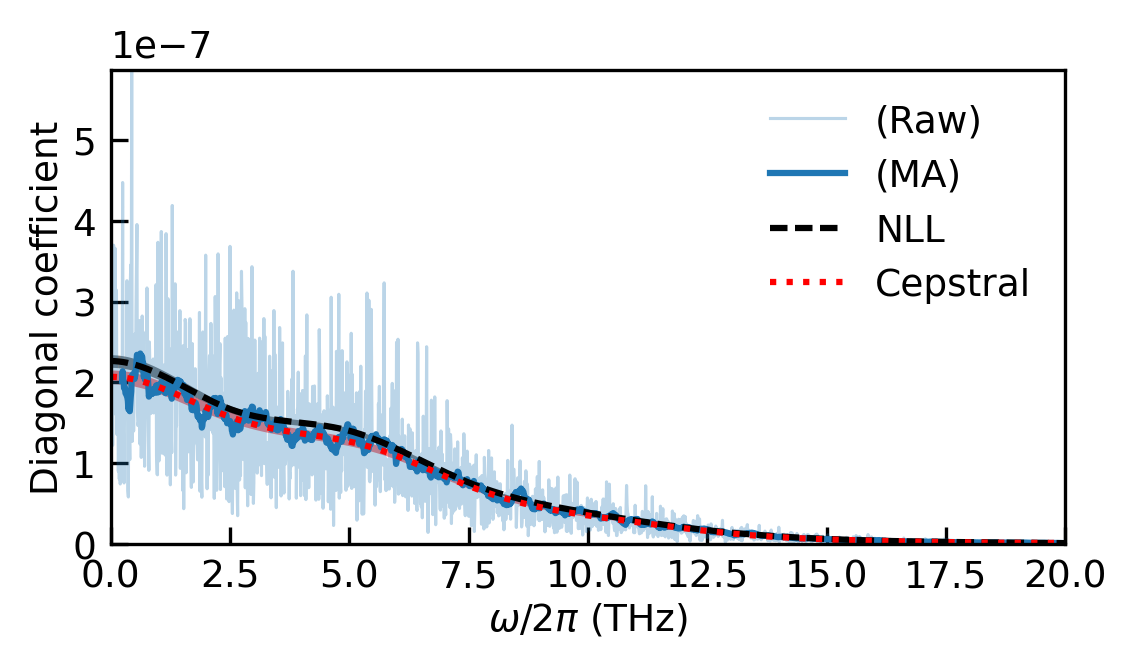

In [878]:
# omega = flux_resample.maxlike.omega
# estimate = flux_resample.NLL_spline(omega)
# estimate_p = flux_resample.NLL_spline_upper(omega)
# estimate_m = flux_resample.NLL_spline_lower(omega)

data_chisquare = flux_resample.psd
estimate = flux_resample.NLL_mean
estimate_p = flux_resample.NLL_upper
estimate_m = flux_resample.NLL_lower

ip = 0
addaxes = []

N = data_chisquare.shape[-1]
fs = plt.rcParams['figure.figsize']

fig, ax = plt.subplots()

pl, = ax.plot(flux_resample.freqs_THz, 
                data_chisquare*flux_resample.KAPPA_SCALE/2, 
                alpha = 0.3, 
                label = f'(Raw)',
        )

ax.plot(flux_resample.freqs_THz, 
        pd.Series(data_chisquare).rolling(window=25).mean()*flux_resample.KAPPA_SCALE/2, 
        alpha = 1, 
        label = f'(MA)', 
        lw = 1.5,
        color = pl.get_color()
        )

ymin, ymax = ax.get_ylim()

x, y = flux_resample.freqs_THz, estimate*flux_resample.KAPPA_SCALE/2
ym, yp = estimate_m*flux_resample.KAPPA_SCALE/2, estimate_p*flux_resample.KAPPA_SCALE/2
ax.plot(x, 
        y, 
        color = 'k',
        lw = 1.5,
        label = 'NLL',
        ls = '--')
ax.fill_between(x, 
                ym, 
                yp, 
                color = 'k', 
                alpha = 0.5)

x, y = flux_resample.freqs_THz, flux_resample.cepf.psd*flux_resample.KAPPA_SCALE/2
y_std = flux_resample.kappa_std/flux_resample.kappa * y
ax.plot(x, 
        y, 
        color = 'r',
        lw = 1.5,
        label = 'Cepstral',
        ls = ':')        
ax.fill_between(x, 
                y-y_std, 
                y+y_std, 
                color = 'r', 
                alpha = 0.5)
        
ax.set_ylim(0,ymax)
ax.set_xlabel('$\omega/2\pi$ (THz)')
ax.set_ylabel('Diagonal coefficient')

ax.legend()

fig.tight_layout()

# Off-diagonal (Seebeck)

To fix: cepstral estimate of the other parameters is missing

In [854]:
# flux_resample.maxlike_estimate(model_scalar, n_parameters=9, likelihood='variance-gamma', 
#                                 solver = 'BFGS',
#                                 minimize_kwargs = {
#                                 'tol': 1e-6,
#                                 'jac': '3-point',
#                                 'options': {'disp': True, 'gtol': 1e-3, 'maxiter': 500, 'eps': 1e-5}
#                                 }
# )
# flux_resample.maxlike.optimizer_res

# Wishart

In [801]:
flux_resample.maxlike_estimate(lambda x, y: mini_model_w_real(x, y, 2), 
                               11 ,
                            #    np.arange(3, 15), 
                               solver = 'BFGS',
                               minimize_kwargs = {
                                'tol': 1e-8,
                                'jac': '3-point',
                                'options': {'disp': True, 'gtol': 1e-4, 'maxiter': 500, 'eps': 1e-6}
                                }
                               )
flux_resample.maxlike.optimizer_res

MaxLikeFilter
Maximum-likelihood estimate with 11 parameters
Spline nodes are equispaced from 0 to the Nyquist frequency.
(11, 2, 2)
Optimization terminated successfully.
         Current function value: 64491.138703
         Iterations: 184
         Function evaluations: 13199
         Gradient evaluations: 197
The BFGS solver features the calculation of the Hessian. The covariance matrix will be estimated through the Laplace approximation.


  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 64491.13870320669
        x: [ 1.178e+00  1.533e+02 ... -4.725e+01  2.168e+01]
      nit: 184
      jac: [-1.530e-06  1.814e-06 ...  3.814e-08  3.602e-07]
 hess_inv: [[ 6.886e-04  9.964e-02 ... -4.149e-04 -1.090e-03]
            [ 9.964e-02  1.242e+03 ...  1.178e-02  1.115e-01]
            ...
            [-4.149e-04  1.178e-02 ...  4.323e+00 -6.368e-02]
            [-1.090e-03  1.115e-01 ... -6.368e-02  6.374e-01]]
     nfev: 13199
     njev: 197

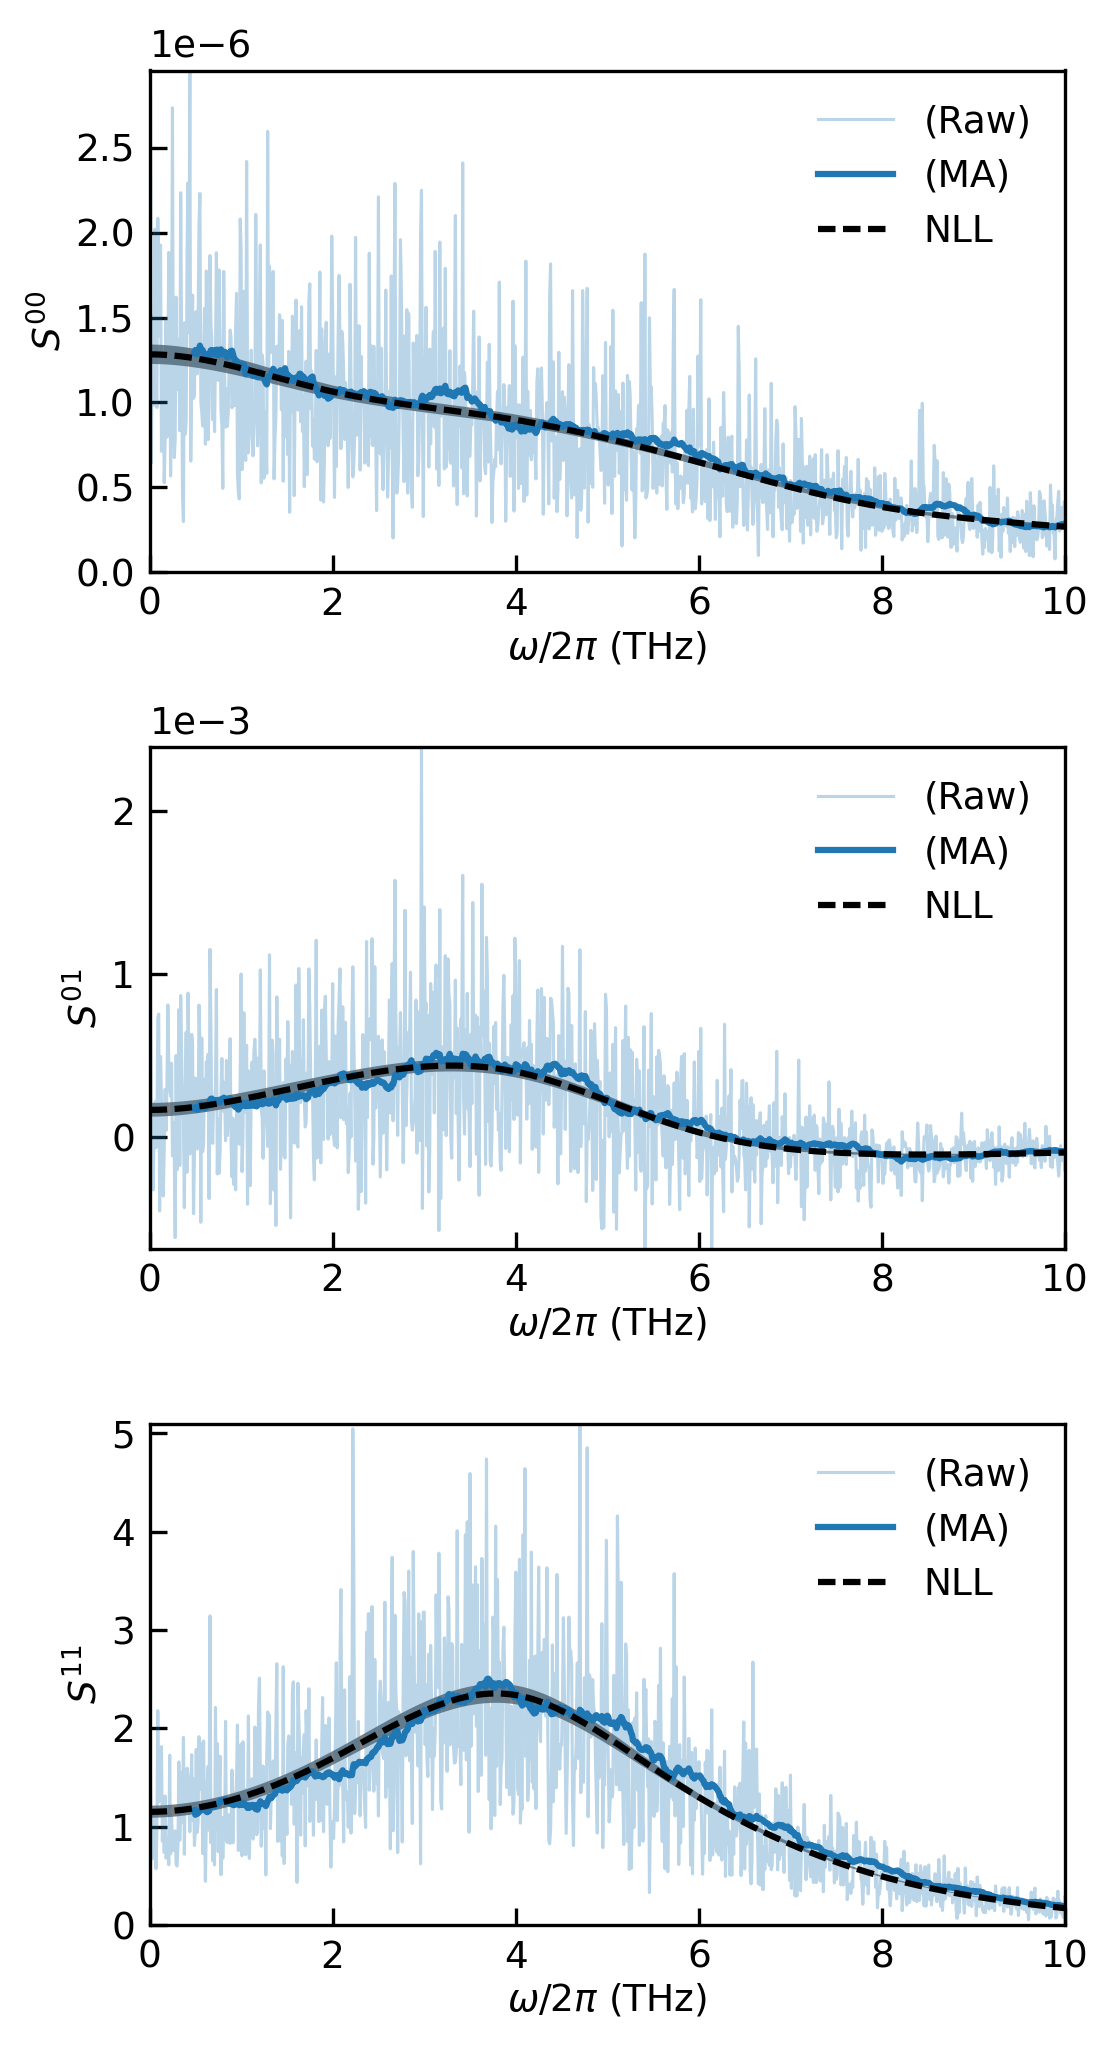

In [802]:
data_wishart = flux_resample.cospectrum.real.transpose((2,0,1))   
estimate = flux_resample.NLL_mean
estimate_p = flux_resample.NLL_upper
estimate_m = flux_resample.NLL_lower

ip = 0
addaxes = []

N = data_wishart.shape[-1]
fs = plt.rcParams['figure.figsize']

fig, axes = plt.subplots(nrows = N*(N+1)//2, ncols = 1, figsize = (fs[0], 3*fs[1]))

for ax, i, j in zip(axes, *np.triu_indices(2)):

        pl, = ax.plot(flux_resample.freqs_THz, 
                        data_wishart[:, i, j]*flux_resample.KAPPA_SCALE/2, 
                        alpha = 0.3, 
                        label = f'(Raw)',
                )

        ax.plot(flux_resample.freqs_THz, 
                pd.Series(data_wishart[:, i, j]).rolling(window=50).mean()*flux_resample.KAPPA_SCALE/2, 
                alpha = 1, 
                label = f'(MA)', 
                lw = 1.5,
                color = pl.get_color()
                )

        x, y = flux_resample.freqs_THz, estimate[:, i, j]*flux_resample.KAPPA_SCALE/2 
        ym, yp = estimate_m[:, i, j]*flux_resample.KAPPA_SCALE/2, estimate_p[:, i, j]*flux_resample.KAPPA_SCALE/2

        ax.plot(x, 
                y, 
                color = 'k',
                lw = 1.5,
                label = 'NLL',
                ls = '--')
                
        ax.fill_between(x, 
                        ym, 
                        yp, 
                        color = 'k', 
                        alpha = 0.5)
        
        ax.set_xlim(0,10)
        ax.set_ylim(0 if i == j else None)
        
        ax.set_xlabel('$\omega/2\pi$ (THz)')
        ax.set_ylabel(f'$S^{{{i}{j}}}$')

        ax.legend()

fig.tight_layout()